# 0. Imports

In [1]:
import sys

sys.path.append("src/")

import os
import random

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from model import *
from skimage import io
from skimage.transform import resize
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from torchvision import ops
from torchvision.models import ResNet50_Weights
from utils import *

# 1. Load Images

In [2]:
class ObjectDetectionDataset(Dataset):
    """
    A Pytorch Dataset class to load the images and their corresponding annotations.

    Returns
    ------------
    images: torch.Tensor of size (B, C, H, W)
    gt bboxes: torch.Tensor of size (B, max_objects, 4)
    gt classes: torch.Tensor of size (B, max_objects)
    """

    def __init__(self, annotation_path, img_dir, img_size, name2idx):
        self.annotation_path = annotation_path
        self.img_dir = img_dir
        self.img_size = img_size
        self.name2idx = name2idx

        self.img_data_all, self.gt_bboxes_all, self.gt_classes_all = self.get_data()

    def __len__(self):
        return self.img_data_all.size(dim=0)

    def __getitem__(self, idx):
        return self.img_data_all[idx], self.gt_bboxes_all[idx], self.gt_classes_all[idx]

    def get_data(self):
        img_data_all = []
        gt_idxs_all = []

        gt_boxes_all, gt_classes_all, img_paths = parse_annotation(
            self.annotation_path, self.img_dir, self.img_size
        )

        for i, img_path in enumerate(img_paths):
            # skip if the image path is not valid
            if (not img_path) or (not os.path.exists(img_path)):
                continue

            # read and resize image
            img = io.imread(img_path)
            img = resize(img, self.img_size)

            # convert image to torch tensor and reshape it so channels come first
            img_tensor = torch.from_numpy(img).permute(2, 0, 1)

            # encode class names as integers
            gt_classes = gt_classes_all[i]
            gt_idx = torch.Tensor([self.name2idx[name] for name in gt_classes])

            img_data_all.append(img_tensor)
            gt_idxs_all.append(gt_idx)

        # pad bounding boxes and classes so they are of the same size
        gt_bboxes_pad = pad_sequence(gt_boxes_all, batch_first=True, padding_value=-1)
        gt_classes_pad = pad_sequence(gt_idxs_all, batch_first=True, padding_value=-1)

        # stack all images
        img_data_stacked = torch.stack(img_data_all, dim=0)

        return img_data_stacked.to(dtype=torch.float32), gt_bboxes_pad, gt_classes_pad

In [3]:
img_width = 640
img_height = 480
annotation_path = "data/annotations.xml"
image_dir = os.path.join("data", "images")
name2idx = {"pad": -1, "camel": 0, "bird": 1}
idx2name = {v: k for k, v in name2idx.items()}

## 1.1. Create Dataset and Dataloaders

In [4]:
od_dataset = ObjectDetectionDataset(
    annotation_path, image_dir, (img_height, img_width), name2idx
)

In [5]:
od_dataloader = DataLoader(od_dataset, batch_size=2)

## 1.2. Grab a batch for demonstration

In [6]:
for img_batch, gt_bboxes_batch, gt_classes_batch in od_dataloader:
    img_data_all = img_batch
    gt_bboxes_all = gt_bboxes_batch
    gt_classes_all = gt_classes_batch
    break

# The followings are commented by me (Seems redundant)
# img_data_all = img_data_all[:2]
# gt_bboxes_all = gt_bboxes_all[:2]
# gt_classes_all = gt_classes_all[:2]

## 1.3. Display Images and Bounding Boxes

In [7]:
# get class names
gt_class_1 = gt_classes_all[0].long()
gt_class_1 = [idx2name[idx.item()] for idx in gt_class_1]

gt_class_2 = gt_classes_all[1].long()
gt_class_2 = [idx2name[idx.item()] for idx in gt_class_2]

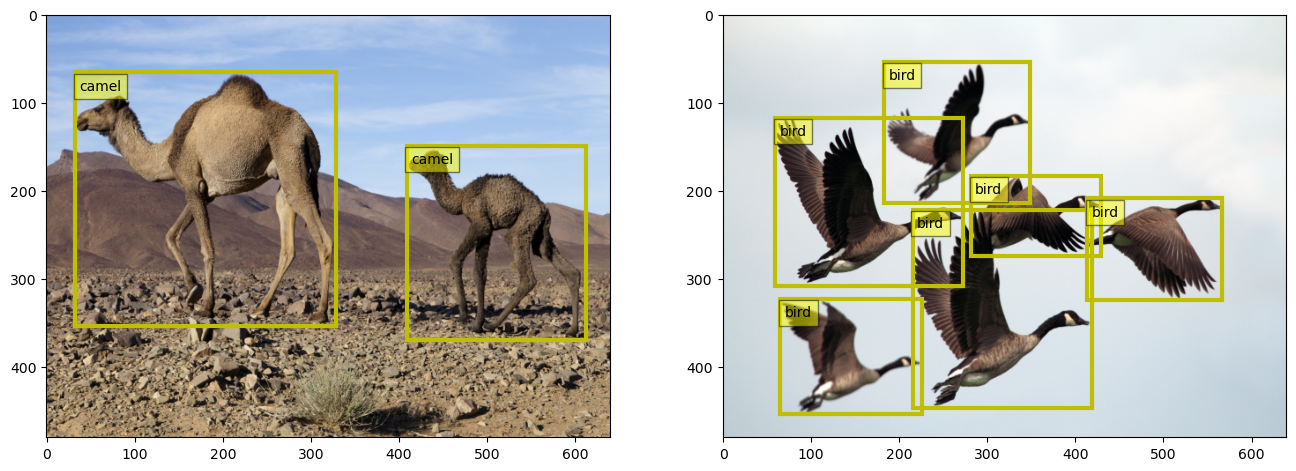

In [8]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_all, fig, axes)
fig, _ = display_bbox(gt_bboxes_all[0], fig, axes[0], classes=gt_class_1)
fig, _ = display_bbox(gt_bboxes_all[1], fig, axes[1], classes=gt_class_2)

# 2. Convolutional Backbone Network

Here we’ll use ResNet 50 as the backbone network. Remember, a single block in ResNet 50 is composed of stacks of bottleneck layers. The Image gets reduced in half after each block along the spatial dimension while the number of channels get doubled. A bottleneck layer is composed of three convolutional layers along with a skip connection as shown below:

<img src="images/bottleneck_layer.png" style="width:500px;height:400px;background-color:white">

We will use the first 4 layers of resnet50 as our convolutional backbone.

In [9]:
model = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)

In [10]:
req_layers = list(model.children())[:8]

In [11]:
backbone = nn.Sequential(*req_layers)

In [12]:
# unfreeze all the parameters
for param in backbone.named_parameters():
    param[1].requires_grad = True

In [13]:
# run the image through the backbone
out = backbone(img_data_all)

In [14]:
out.shape

torch.Size([2, 2048, 15, 20])

In [15]:
out_c, out_h, out_w = out.size(dim=1), out.size(dim=2), out.size(dim=3)

In [16]:
out_c, out_h, out_w

(2048, 15, 20)

## 2.1. Check how much the image has been down-scaled

In [17]:
width_scale_factor = img_width // out_w
height_scale_factor = img_height // out_h
height_scale_factor, width_scale_factor

(32, 32)

## 2.2. Visualize feature maps

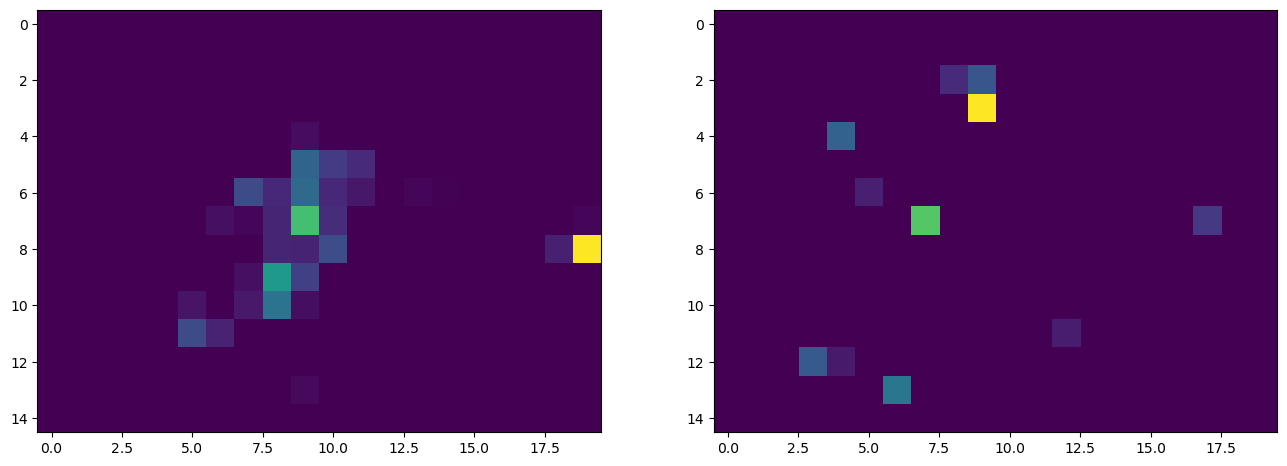

In [18]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

filters_data = [filters[0].detach().numpy() for filters in out[:2]]

fig, axes = display_img(filters_data, fig, axes)

# 2.3. Generate and Plot Anchor Points

In [19]:
anc_pts_x, anc_pts_y = gen_anc_centers(out_size=(out_h, out_w))

## 2.4. Display Grid Mapping

In [20]:
# project anchor centers onto the original image
anc_pts_x_proj = anc_pts_x.clone() * width_scale_factor
anc_pts_y_proj = anc_pts_y.clone() * height_scale_factor

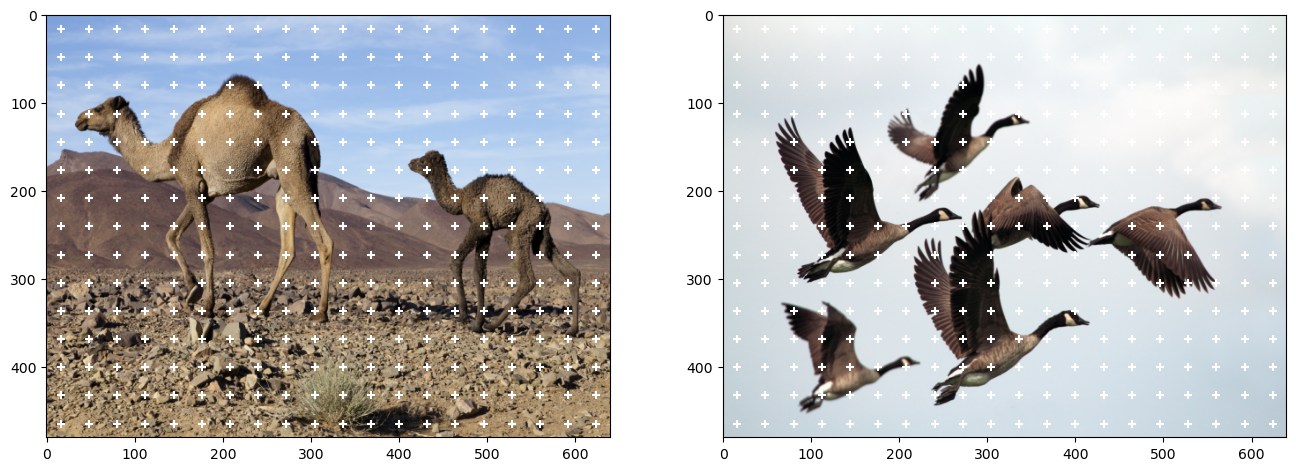

In [21]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_all, fig, axes)
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[0])
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[1])

## 2.5. Create Anchor Boxes around Anchor points

In [22]:
anc_scales = [2, 4, 6]
anc_ratios = [0.5, 1, 1.5]
n_anc_boxes = len(anc_scales) * len(
    anc_ratios
)  # number of anchor boxes for each anchor point

anc_base = gen_anc_base(anc_pts_x, anc_pts_y, anc_scales, anc_ratios, (out_h, out_w))

In [23]:
# since all the images are scaled to the same size
# we can repeat the anchor base for all the images
anc_boxes_all = anc_base.repeat(img_data_all.size(dim=0), 1, 1, 1, 1)

## 2.5.1. plot anchor boxes on a single anchor point

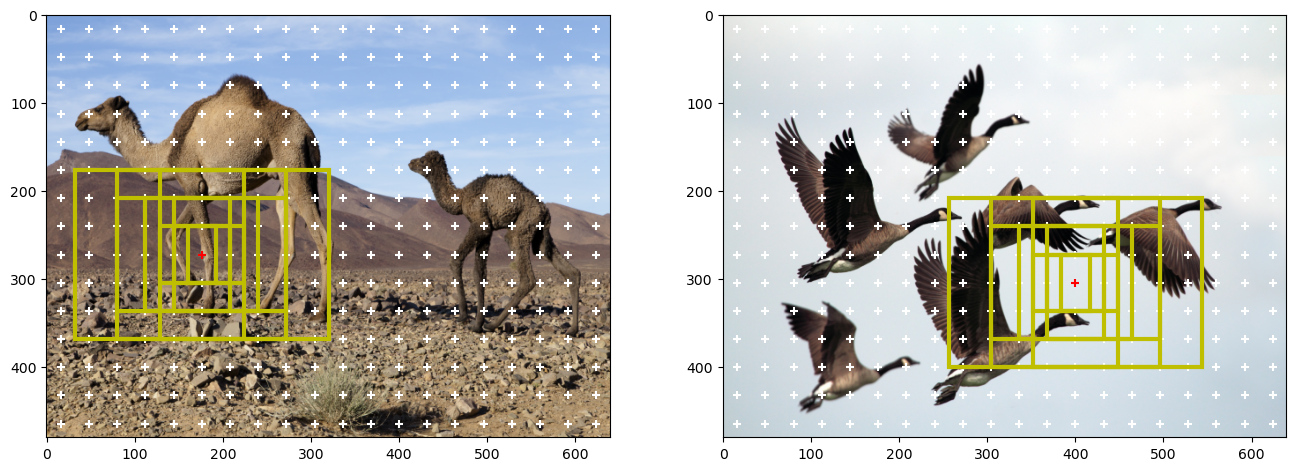

In [24]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_all, fig, axes)

# project anchor boxes to the image
anc_boxes_proj = project_bboxes(
    anc_boxes_all, width_scale_factor, height_scale_factor, mode="a2p"
)

# plot anchor boxes around selected anchor points
sp_1 = [5, 8]
sp_2 = [12, 9]
bboxes_1 = anc_boxes_proj[0][sp_1[0], sp_1[1]]
bboxes_2 = anc_boxes_proj[1][sp_2[0], sp_2[1]]

fig, _ = display_grid(
    anc_pts_x_proj,
    anc_pts_y_proj,
    fig,
    axes[0],
    (anc_pts_x_proj[sp_1[0]], anc_pts_y_proj[sp_1[1]]),
)
fig, _ = display_grid(
    anc_pts_x_proj,
    anc_pts_y_proj,
    fig,
    axes[1],
    (anc_pts_x_proj[sp_2[0]], anc_pts_y_proj[sp_2[1]]),
)
fig, _ = display_bbox(bboxes_1, fig, axes[0])
fig, _ = display_bbox(bboxes_2, fig, axes[1])

## 2.5.2. plot all anchor boxes

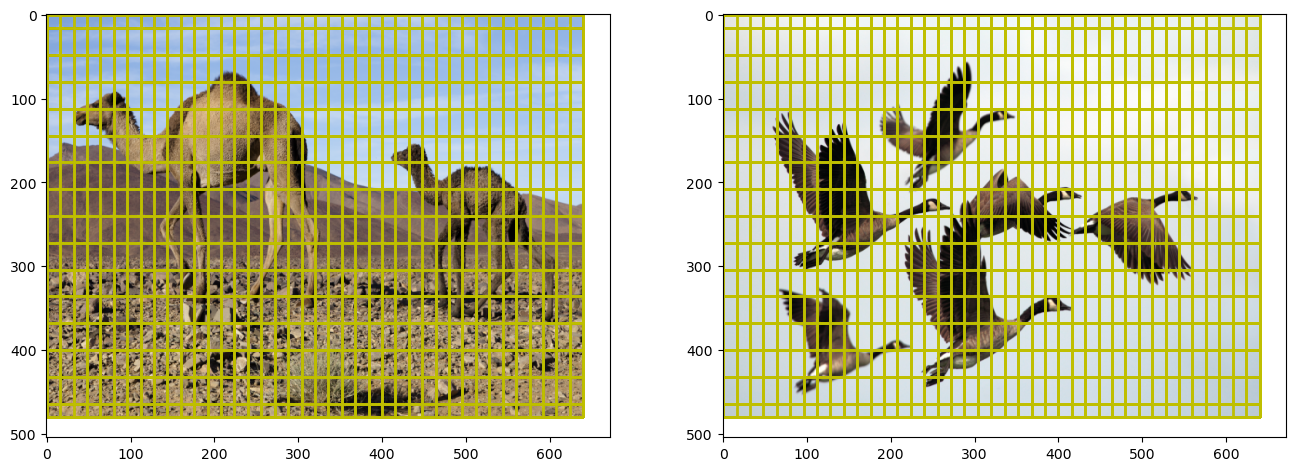

In [25]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_all, fig, axes)

# plot feature grid
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[0])
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[1])

# plot all anchor boxes
for x in range(anc_pts_x_proj.size(dim=0)):
    for y in range(anc_pts_y_proj.size(dim=0)):
        bboxes = anc_boxes_proj[0][x, y]
        fig, _ = display_bbox(bboxes, fig, axes[0], line_width=1)
        fig, _ = display_bbox(bboxes, fig, axes[1], line_width=1)

## 2.6. Get Positive and Negative Anchors

In [26]:
pos_thresh = 0.7
neg_thresh = 0.3

# project gt bboxes onto the feature map
gt_bboxes_proj = project_bboxes(
    gt_bboxes_all, width_scale_factor, height_scale_factor, mode="p2a"
)

In [27]:
(
    positive_anc_ind,
    negative_anc_ind,
    GT_conf_scores,
    GT_offsets,
    GT_class_pos,
    positive_anc_coords,
    negative_anc_coords,
    positive_anc_ind_sep,
) = get_req_anchors(
    anc_boxes_all, gt_bboxes_proj, gt_classes_all, pos_thresh, neg_thresh
)

### 2.6.1. Visualize positive anchor coordinates

In [28]:
# project anchor coords to the image space
pos_anc_proj = project_bboxes(
    positive_anc_coords, width_scale_factor, height_scale_factor, mode="a2p"
)
neg_anc_proj = project_bboxes(
    negative_anc_coords, width_scale_factor, height_scale_factor, mode="a2p"
)

# grab +ve and -ve anchors for each image separately

anc_idx_1 = torch.where(positive_anc_ind_sep == 0)[0]
anc_idx_2 = torch.where(positive_anc_ind_sep == 1)[0]

pos_anc_1 = pos_anc_proj[anc_idx_1]
pos_anc_2 = pos_anc_proj[anc_idx_2]

neg_anc_1 = neg_anc_proj[anc_idx_1]
neg_anc_2 = neg_anc_proj[anc_idx_2]

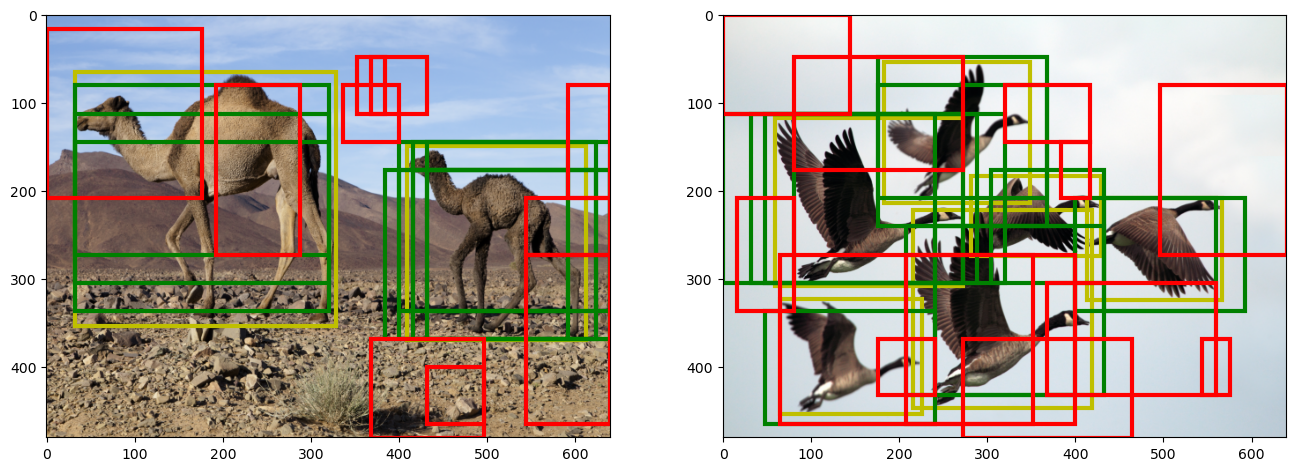

In [29]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_all, fig, axes)

# plot groundtruth bboxes
fig, _ = display_bbox(gt_bboxes_all[0], fig, axes[0])
fig, _ = display_bbox(gt_bboxes_all[1], fig, axes[1])

# plot positive anchor boxes
fig, _ = display_bbox(pos_anc_1, fig, axes[0], color="g")
fig, _ = display_bbox(pos_anc_2, fig, axes[1], color="g")

# plot negative anchor boxes
fig, _ = display_bbox(neg_anc_1, fig, axes[0], color="r")
fig, _ = display_bbox(neg_anc_2, fig, axes[1], color="r")

## 2.7. Building the model

In [30]:
img_size = (img_height, img_width)
out_size = (out_h, out_w)
n_classes = len(name2idx) - 1  # exclude pad idx
roi_size = (2, 2)

detector = TwoStageDetector(img_size, out_size, out_c, n_classes, roi_size)

C:\Users\johnw\miniconda3\envs\opencv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\johnw\miniconda3\envs\opencv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [31]:
detector.eval()
total_loss = detector(img_batch, gt_bboxes_batch, gt_classes_batch)
proposals_final, conf_scores_final, classes_final = detector.inference(img_batch)

## 2.8. Training loop

In [32]:
def training_loop(model, learning_rate, train_dataloader, n_epochs):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.train()
    loss_list = []

    for i in tqdm(range(n_epochs)):
        total_loss = 0
        for img_batch, gt_bboxes_batch, gt_classes_batch in train_dataloader:
            # forward pass
            loss = model(img_batch, gt_bboxes_batch, gt_classes_batch)

            # backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        loss_list.append(total_loss)

    return loss_list

In [33]:
learning_rate = 1e-3
n_epochs = 1000

loss_list = training_loop(detector, learning_rate, od_dataloader, n_epochs)

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [1:40:02<00:00,  6.00s/it]


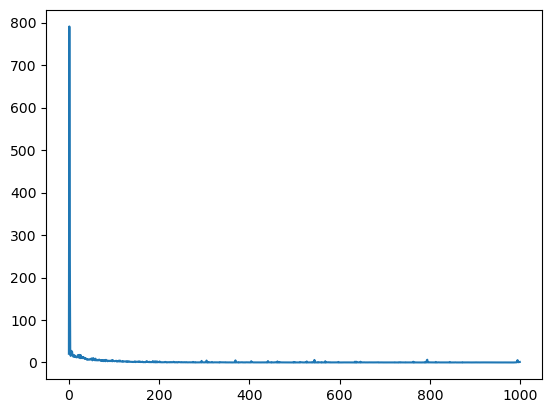

In [34]:
plt.plot(loss_list)

### 2.8.1. save model

In [35]:
torch.save(detector, "medium_detector_model.pt")

# 3. Inference

In [51]:
img_batch.shape

torch.Size([2, 3, 480, 640])

In [53]:
detector.eval()
proposals_final, conf_scores_final, classes_final = detector.inference(
    img_batch, conf_thresh=0.99, nms_thresh=0.05
)

In [54]:
proposals_final

[tensor([[ 3.3821e+00,  9.6979e+00,  5.6361e+00,  1.3735e+01],
         [ 8.6930e+00,  3.6929e+00,  1.4951e+01,  9.7741e+00],
         [-2.6086e+02, -1.8228e+03,  2.7185e+02,  1.8604e+03],
         [ 1.1874e+01, -3.2505e+00,  1.2729e+01,  6.1444e+00],
         [-3.3895e+00,  6.6717e-01, -3.3581e+00,  7.0859e-01]]),
 tensor([], size=(0, 4))]

In [55]:
# project proposals to the image space
prop_proj_1 = project_bboxes(
    proposals_final[0], width_scale_factor, height_scale_factor, mode="a2p"
)
# prop_proj_2 = project_bboxes(
#     proposals_final[1], width_scale_factor, height_scale_factor, mode="a2p"
# )

# get classes
classes_pred_1 = [idx2name[cls] for cls in classes_final[0].tolist()]
classes_pred_2 = [idx2name[cls] for cls in classes_final[1].tolist()]

In [59]:
img_batch.shape

torch.Size([2, 3, 480, 640])

In [60]:
prop_proj_1.shape

torch.Size([5, 4])

In [64]:
classes_pred_1

['bird', 'bird', 'bird', 'bird', 'bird']

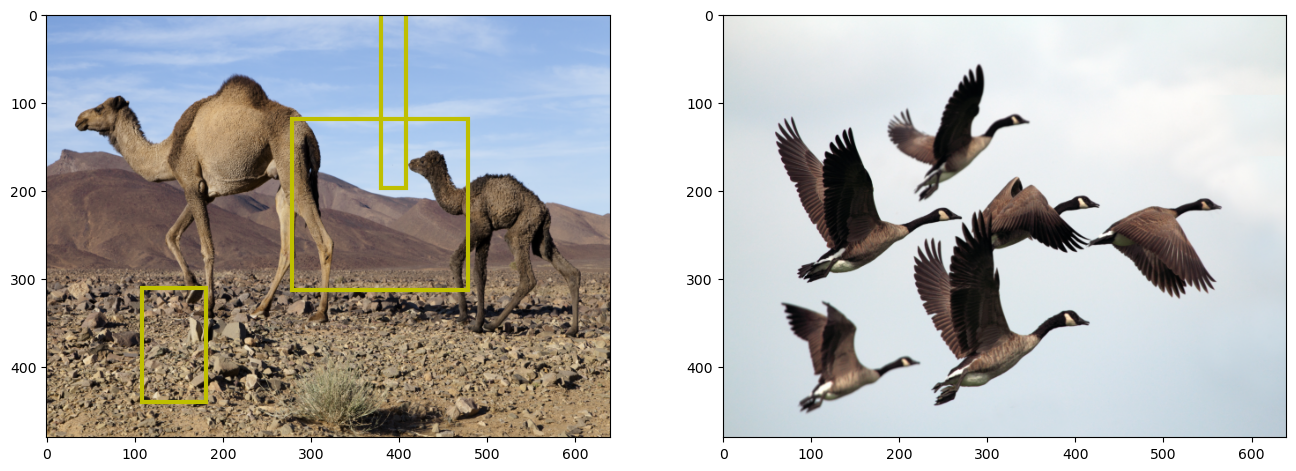

In [65]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_batch, fig, axes)
fig, _ = display_bbox(prop_proj_1, fig, axes[0])#, classes=classes_pred_1)
# fig, _ = display_bbox(prop_proj_2, fig, axes[1], classes=classes_pred_2)